# Prepare training and testing data using:

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

## Holdout method

In [39]:
foods = pd.read_csv("FAO database.csv", encoding='latin1')
pd.set_option('max_column', None)
usa_foods = foods.query('Area == "United States of America"')
usa_foods.head(3)

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
20394,US,231,United States of America,2511,Wheat and products,5521,Feed,1000 tonnes,37.09,-95.71,1197.0,944.0,778.0,1494.0,3971.0,2735.0,1002.0,4259.0,5127.0,5253.0,7141.0,5430.0,3405.0,950.0,1015.0,2025.0,5239.0,4287.0,2338.0,1606.0,3669.0,5302.0,10103.0,11082.0,7735.0,10919.0,7898.0,4096.0,3786.0,13129.0,6654.0,5269.0,7395.0,9376.0,4183.0,8372.0,6818.0,10650.0,7846.0,8164.0,4953.0,3157.0,5524.0,4953.0,4354.0,3187.0,436.0,6260.0,4899.0,3620.0,4898.0,9943,6196
20395,US,231,United States of America,2511,Wheat and products,5142,Food,1000 tonnes,37.09,-95.71,13439.0,13314.0,13320.0,13525.0,13510.0,13479.0,13717.0,13840.0,13916.0,13825.0,13910.0,14011.0,14535.0,14524.0,15168.0,15918.0,15539.0,15644.0,16130.0,16151.0,16223.0,16859.0,16665.0,17260.0,18038.0,18513.0,19308.0,19635.0,19401.0,20657.0,20989.0,21680.0,22639.0,23095.0,25662.0,23749.0,23938.0,24398.0,24301.0,25393.0,24947.0,24315.0,24801.0,24511.0,24869.0,25250.0,25793.0,25302.0,24959.0,25167.0,25050.0,25757,25742
20396,US,231,United States of America,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,37.09,-95.71,481.0,574.0,518.0,564.0,620.0,589.0,611.0,645.0,695.0,566.0,655.0,609.0,619.0,676.0,700.0,643.0,716.0,532.0,885.0,888.0,1054.0,1163.0,985.0,867.0,912.0,1179.0,1460.0,1475.0,1559.0,1730.0,1851.0,1916.0,1834.0,2046.0,2236.0,2151.0,2284.0,2349.0,2056.0,2007.0,2026.0,2120.0,1827.0,1943.0,2021.0,2075.0,2104.0,2104.0,2118.0,2194.0,2127.0,2175,2203


Text(0.5, 1.0, 'US Food Consumption, Normalized, 20 Categories')

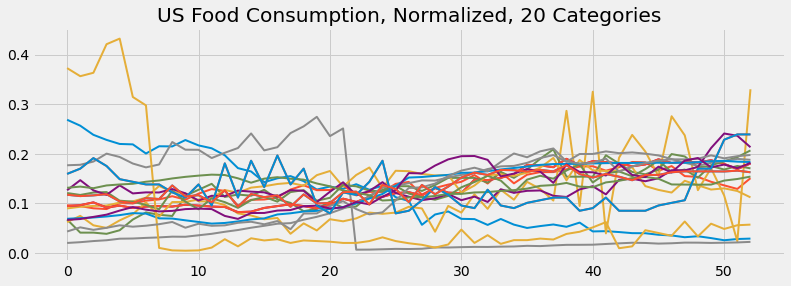

In [40]:
X = usa_foods.loc[:, ['Y{0}'.format(y) for y in range(1961, 2014)]].replace(0, np.nan)
X = X.dropna(thresh=30)
X = X.fillna(method='backfill')
X = normalize(X)

X = X[(np.max(X, axis=1) - np.min(X, axis=1)) / np.min(X, axis=1) < 10**2, :]

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(12, 4))
for n in np.random.choice(range(X.shape[1]), size=20):
    plt.plot(X[n, :],linewidth=2)
    
plt.title('US Food Consumption, Normalized, 20 Categories')

In [41]:
X, y = X[:, :-1], X[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [42]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_test_hat = clf.predict(X_test)

from sklearn.metrics import median_absolute_error
median_absolute_error(y_test_hat, y_test)

0.023716083349389613

In [43]:
median_absolute_error(clf.predict(X_train), y_train)

0.00221303501937703

## K-fold Cross-validation method

In [44]:
kf = KFold(n_splits=6)

scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores.append(
        median_absolute_error(clf.fit(X_train, y_train).predict(X_test), y_test)
    )
    
np.mean(scores)

0.017993801387054878

## Leave-one-out cross-validation

In [45]:
loo = LeaveOneOut()

scores = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores.append(
        median_absolute_error(clf.fit(X_train, y_train).predict(X_test), y_test)
    )
    
scores = np.array(scores)
np.mean(scores)

0.02618378635961042

## Bootstrap sampling

In [46]:
data = pd.read_csv('pima-indians-diabetes.csv')
data.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [47]:
n_iterations = 10
n_size = int(len(data) * 0.50)

In [50]:
#Bootstrap-ing
stats = list()
for i in range(n_iterations):
    train = resample(values, n_samples = n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    
    model = DecisionTreeClassifier()
    model.fit(train[:,:-1], train[:,-1])
    
    predictions = model.predict(test[:,:-1]) 
    score = accuracy_score(test[:,-1], predictions)
    
    print(score)
    stats.append(score)

0.665938864628821
0.67170626349892
0.7194860813704497
0.6888412017167382
0.7098901098901099
0.7048458149779736
0.697228144989339
0.6911447084233261
0.6984815618221258
0.6895074946466809


<Figure size 720x360 with 0 Axes>

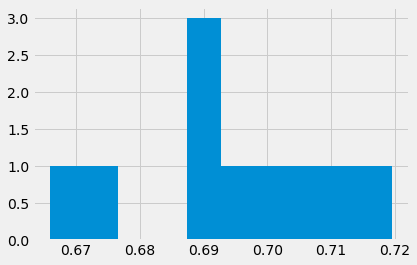

<Figure size 720x360 with 0 Axes>

In [51]:
plt.hist(stats)
plt.figure(figsize = (10,5))

In [52]:
#Confidence Intervals
a = 0.95 
p = ((1.0 - a)/2.0) * 100 
lower = max(0.0, np.percentile(stats,p))

p = (a + ((1.0 - a)/ 2.0)) * 100
upper = min(1.0, np.percentile(stats,p))
print('%.1f confidence interval %.1f%% and %.1f%%' %(a*100, lower*100, upper*100))

95.0 confidence interval 66.7% and 71.7%
